### Camera Simulator

This is a first stab at a camera simulator or "digital twin" using python. ChatGPT was used for reference and Q&A.

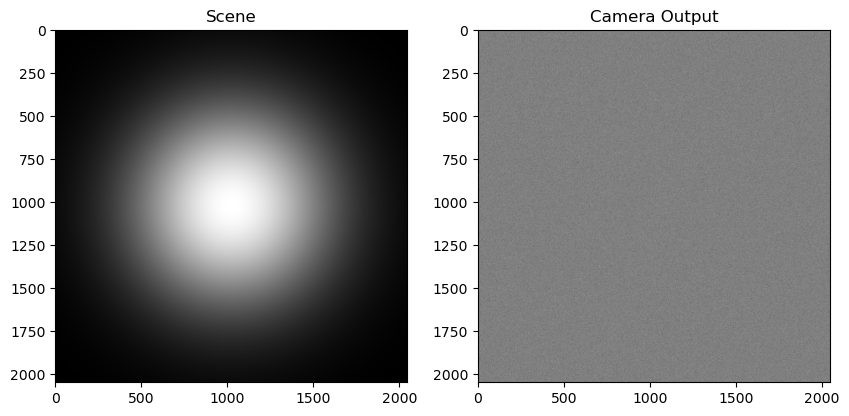

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
image_width = 2048
image_height = 2048
exposure_time = 0.1  # Exposure time in seconds

# Simulate photon shot noise
def simulate_photon_noise(image):
    """
    Simulates photon shot noise. This noise is inherent to the randomness of photon arrivals.
    :param image: The initial image data (electron counts).
    :return: Simulated image data with added photon noise.
    """
    return np.random.poisson(image)

# Simulate read noise
def simulate_read_noise(image, read_noise_std):
    """
    Simulates read noise. This noise is introduced during the readout process of the sensor.
    :param image: The image data (electron counts) before read noise.
    :param read_noise_std: Standard deviation of the read noise.
    :return: Simulated image data with added read noise.
    """
    return image + np.random.normal(0, read_noise_std, image.shape)

# Simulate dark current noise
def simulate_dark_current(image, dark_current_rate, exposure_time):
    """
    Simulates dark current noise. Dark current is generated by the sensor even in the absence of light.
    :param image: The image data (electron counts) before dark current noise.
    :param dark_current_rate: Dark current rate in electrons per second per pixel.
    :param exposure_time: Exposure time in seconds.
    :return: Simulated image data with added dark current noise.
    """
    dark_noise = np.random.poisson(dark_current_rate * exposure_time, image.shape)
    return image + dark_noise

# Simulate CMOS camera
def simulate_cmos_camera(scene, exposure_time, read_noise_std, dark_current_rate):
    """
    Simulates the behavior of a CMOS camera sensor.
    :param scene: The input scene (e.g., a grayscale image).
    :param exposure_time: Exposure time in seconds.
    :param read_noise_std: Standard deviation of read noise.
    :param dark_current_rate: Dark current rate in electrons per second per pixel.
    :return: Simulated camera sensor output with photon noise, read noise, and dark current noise.
    """
    sensor_response = scene * exposure_time  # Apply exposure time
    sensor_response = simulate_photon_noise(sensor_response)  # Simulate photon shot noise
    sensor_response = simulate_read_noise(sensor_response, read_noise_std)  # Simulate read noise
    sensor_response = simulate_dark_current(sensor_response, dark_current_rate, exposure_time)  # Simulate dark current
    return sensor_response

# Create a structured scene with a 2D Gaussian distribution
x, y = np.meshgrid(np.linspace(0, 1, image_width), np.linspace(0, 1, image_height))
center_x, center_y = 0.5, 0.5  # Center of the Gaussian distribution
std_x, std_y = 0.2, 0.2  # Standard deviation for the Gaussian distribution

scene = np.exp(-((x - center_x) ** 2 / (2 * std_x ** 2) + (y - center_y) ** 2 / (2 * std_y ** 2)))

# Create a simple scene (grayscale)
# scene = np.random.rand(image_height, image_width)

# Simulate CMOS camera response with proper scaling
sensor_response = simulate_cmos_camera(scene, exposure_time=exposure_time, read_noise_std=5, dark_current_rate=0.01)

# Display the scene and camera output
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Scene")
plt.imshow(scene, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Camera Output")
# Scale the sensor response for visualization purposes
camera_output = sensor_response
plt.imshow(camera_output, cmap='gray')

plt.show()

In [3]:
%pwd

'/Users/pbecerra/Library/CloudStorage/Dropbox/UNIBE/CAS_Bern/datascience/Applied-Data-Science-git/Module-1/M1_Web_Scraping/1-Tutorials'

In [9]:
%cd /Users/pbecerra/Dropbox/MCSE_workspace/cam_sim

/Users/pbecerra/Library/CloudStorage/Dropbox/MCSE_workspace/cam_sim


In [10]:
%pwd

'/Users/pbecerra/Library/CloudStorage/Dropbox/MCSE_workspace/cam_sim'